In [1]:
import os
import pandas as pd
import numpy as np

from mlcomp.config import DATA_PATH
from mlcomp.data import load_csv_data
from mlcomp.helpers import split_data
from mlcomp.performance import correctness
from mlcomp.models import ridge_regression

import matplotlib.pyplot as plt
%matplotlib inline  

TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')
RATIO_SPLIT = 0.3
SEED_SPLIT = 872
CURRENT_CUTOFF = 0

In [54]:
# split function `predict_labels` in `predict_values` and 
# another `predict` that is able to deal with a cutoff

def predict_values(weights, X):
    return np.dot(X, weights)

def predict(y_values, cutoff):
    labels = np.empty(len(y_values))
    labels[y_values <= cutoff] = -1
    labels[y_values > cutoff] = 1
    
    return labels

In [14]:
y, X, ids = load_csv_data(TRAIN_PATH)
X_train, X_test, y_train, y_test = split_data(X, y, RATIO_SPLIT, seed=SEED_SPLIT)

In [28]:
weights = ridge_regression(y_train, X_train, lambda_=1)[0]
y_hat_train = predict_values(weights, X_train)
y_hat_test = predict_values(weights, X_test)

## Analyse distribution of predictions in train dataset

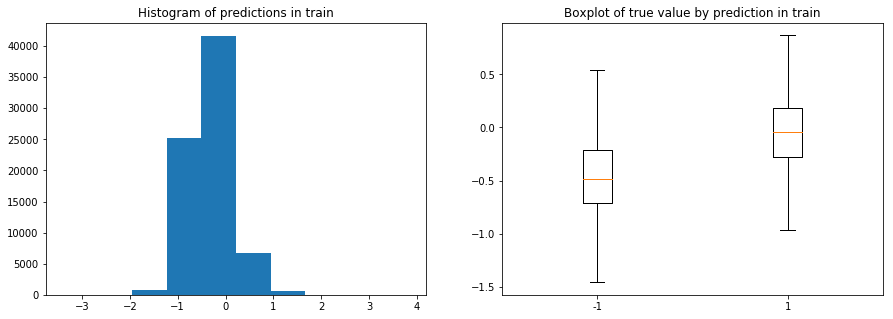

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(15, 5)

ax1.hist(y_hat_train);
ax1.set_title('Histogram of predictions in train');

ax2.boxplot([y_hat_train[y_train == -1], y_hat_train[y_train == 1]], 
            labels=['-1', '1'], 
            showfliers=False);
ax2.set_title('Boxplot of true value by prediction in train');

This might indicate that 0 as cutoff might not be the best option

## Finding best cutoff in train set

In [70]:
def correct_by_cutoff(y_true, y_pred, search_space):
    labels = list(map(lambda c: predict(y_pred, c), search_space))
    corrects = list(map(lambda l: correctness(y_true, l), labels))
    return corrects

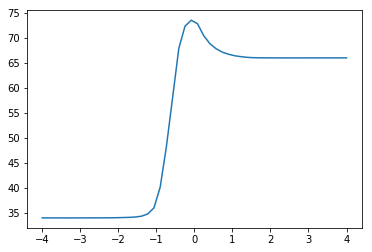

In [72]:
cutoff_search_space = np.linspace(-4, 4, retstep=0.01)[0]
correctness_by_cutoff = correct_by_cutoff(y_train, y_hat_train, cutoff_search_space)
plt.plot(cutoff_search_space, correctness_by_cutoff);

In [76]:
best_cutoff = cutoff_search_space[correctness_by_cutoff.index(max(correctness_by_cutoff))]
print('Best cutoff in train: {}'.format(best_cutoff))

Best cutoff in train: -0.08163265306122458


In [79]:
print('Correctness in test with cutoff 0: {}'.format(correctness(y_test, predict(y_hat_test, 0))))
print('Correctness in test with best cutoff: {}'.format(correctness(y_test, predict(y_hat_test, best_cutoff))))

Correctness in test with cutoff 0: 73.29142857142857
Correctness in test with best cutoff: 73.58228571428572
